In [21]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy.linalg import norm, pinv

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras import Model

%matplotlib inline

# Load and Process Data

In [2]:
# Load and show sheet 1
df = pd.read_csv("MFS1000.csv")
df.columns = ['Index', 'MPerm', 'Mporo',
              'GasDen', 'Stage', 'L_ave', 'W_ave',
              'Perm_ave', 'DFN_realization','t','qg','qw','bhp']
clist = list(df.columns)
clist_new = clist[:]
df = df[clist_new]
df = df.loc[:, ['Index', 'MPerm', 'Mporo',
              'GasDen', 'Stage', 'L_ave', 'W_ave',
              'Perm_ave', 'DFN_realization','t','bhp','qg','qw',]]
df.head(10)

,Index,MPerm,Mporo,GasDen,Stage,L_ave,W_ave,Perm_ave,DFN_realization,t,bhp,qg,qw
0,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,0.993374,7508.179688,4547636.50,310.362976
1,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,7.000000,7508.179688,4054408.50,175.986694
2,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,14.000000,7444.569824,3795020.25,135.125015
3,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,21.000000,7381.249023,3603605.75,114.067642
4,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,28.000000,7318.217285,3449824.25,99.095901
5,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,35.000000,7255.475098,3319816.50,88.332123
6,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,42.000000,7193.021484,3207557.00,79.422333
7,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,49.000000,7130.857422,3106779.25,72.017845
8,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,56.000000,7068.981934,3015132.75,65.786911
9,1.0,0.000828,0.043252,0.6619,21.0,245.4466,43.9506,11599.3988,7.0,63.000000,7007.395996,2931013.75,60.471268


In [3]:
# Extract the static and dynamic columns
data_cols = list(list(df)[i] for i in list(range(1,13)))
print(data_cols)
data = df[data_cols].astype(float).to_numpy()

['MPerm', 'Mporo', 'GasDen', 'Stage', 'L_ave', 'W_ave', 'Perm_ave', 'DFN_realization', 't', 'bhp', 'qg', 'qw']


## Normalization

In [8]:
# Data Normalozation
norm_data = data
scaler = MinMaxScaler()
scaler.fit(data)
norm_data = scaler.transform(norm_data)

max_qg = np.max(data[:,-2])
min_qg = np.min(data[:,-2])
max_qw = np.max(data[:,-1])
min_qw = np.min(data[:,-1])
print(norm_data.shape)

(157000, 12)


In [9]:
t_steps = 157 #reshaped time steps
data_total = norm_data.reshape(1000,t_steps,data.shape[1])
data_total_list = data_total.tolist()
random.Random(99).shuffle(data_total_list)
data_total = np.array(data_total_list)

## Separate Training and Testing Data

In [34]:
# Training ata
tr_por = 900
x = data_total[:tr_por,:,:]
x_test = data_total[tr_por:,:,:]
print(x.shape)
print(x_test.shape)

(900, 157, 12)
(100, 157, 12)


## Perfrom Delay on the Dynamic Data

In [35]:
def delay_embedding(train,m,d):
    trainX = []
    trainY = []
    for i in range(len(train)-m*d):
        trainX.append(train[i:i+m*d:d, [0,1,2,3,6,7,8,10,11]])
        trainY.append(train[i+m*d-d+1, [-3,-2,-1]]) # colume want to predict

    return np.array(trainX), np.array(trainY)

In [38]:
d = 1 # delay, inteval betweem dates 
m = 1  # dimentionality, how many past dates
trainXX = []
trainYY = []
for i_delay in range(x.shape[0]):
    train_i = x[i_delay,:,:] 
    trainX, trainY = delay_embedding(train_i,m,d)
    
    trainXX.append(trainX.tolist())
    trainYY.append(trainY.tolist())
    
trainXX = np.array(trainXX)   
trainYY = np.array(trainYY)   
inputs = trainXX.reshape(tr_por,trainXX.shape[1],trainXX.shape[3])
labels = trainYY.reshape(tr_por,trainYY.shape[1],trainYY.shape[2])
print('Input shape == {}'.format(inputs.shape))
print('Label shape == {}'.format(labels.shape))

inputs2 = np.concatenate((inputs,labels),axis=2)
inputs2 = np.delete(inputs2,[10,11],axis=2)
inputs2[:,:,[0,1,2,3,4,5,6,7,8,9]]=inputs2[:,:,[0,1,2,3,4,5,6,9,7,8]]
labels2 = np.delete(labels,[0],axis=2)
print('Input shape == {}'.format(inputs2.shape))
print('Label shape == {}'.format(labels2.shape))

Input shape == (900, 156, 9)
Label shape == (900, 156, 3)
Input shape == (900, 156, 10)
Label shape == (900, 156, 2)


In [37]:
testXX = []
testYY = []
for i_delay in range(x_test.shape[0]):
    test_i = x_test[i_delay,:,:] 
    testX, testY = delay_embedding(test_i,m,d)
    
    testXX.append(testX.tolist())
    testYY.append(testY.tolist())
    
testXX = np.array(testXX)   
testYY = np.array(testYY)   
testXX = testXX.reshape(data_test.shape[0],testXX.shape[1],testXX.shape[3])
testYY = testYY.reshape(data_test.shape[0],testYY.shape[1],3)

inputs_test = np.concatenate((testXX,testYY),axis=2)
inputs_test = np.delete(inputs_test,[10,11],axis=2)
inputs_test[:,:,[0,1,2,3,4,5,6,7,8,9]]=inputs_test[:,:,[0,1,2,3,4,5,6,9,7,8]]
labels_test = np.delete(testYY ,[0],axis=2)

print('Test input shape == {}'.format(inputs_test.shape))
print('Test Label shape == {}'.format(labels_test.shape))

Test input shape == (100, 156, 10)
Test Label shape == (100, 156, 2)


Text(0, 0.5, 'Normalized Value')

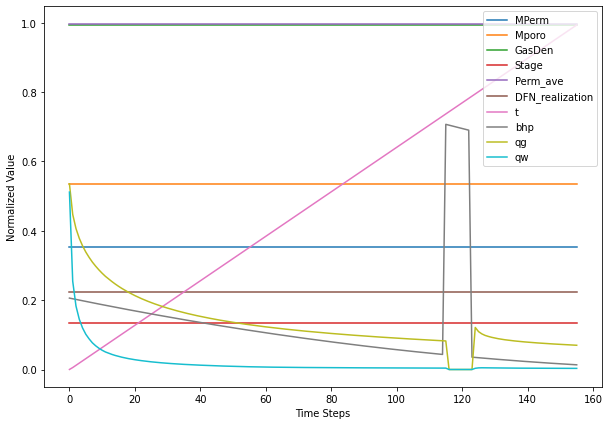

In [18]:
plt.figure(figsize=(10,7))
plt.plot(range(t_steps-1),inputs2[10,:,:])
plt.legend(['MPerm', 'Mporo','GasDen', 'Stage','Perm_ave',
            'DFN_realization','t','bhp','qg','qw'], loc='upper right')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')

# Neural Network

In [31]:
# Define input layer
LSTM_input = Input(shape=(inputs2.shape[1],inputs2.shape[2]),name="Dynamic_Inputs")

# layer 1
rec_layer_one = LSTM(64,return_sequences=True,name ="LSTM_layer1")(LSTM_input)

rec_layer_one = Dropout(0.2,name ="LSTM_ouput_layer1")(rec_layer_one)

# layer 2
rec_layer_two = LSTM(64,return_sequences=True,name ="LSTM_layer2")(rec_layer_one)

rec_layer_two = Dropout(0.2,name ="LSTM_ouput_layer2")(rec_layer_two)

# layer 3
dense_two = Dense(128, activation='tanh',name="Combined_Dense_layer1")(rec_layer_two)
output = Dense(labels2.shape[2],activation='tanh',name="Output_layer")(dense_two)

# Compile ModeL 
# We first train using binary cross entropy loss and then train the same model using focal loss.
model = Model(inputs=LSTM_input,outputs=output)
# binary cross entropy loss
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dynamic_Inputs (InputLayer)  [(None, 156, 10)]        0         
                                                                 
 LSTM_layer1 (LSTM)          (None, 156, 64)           19200     
                                                                 
 LSTM_ouput_layer1 (Dropout)  (None, 156, 64)          0         
                                                                 
 LSTM_layer2 (LSTM)          (None, 156, 64)           33024     
                                                                 
 LSTM_ouput_layer2 (Dropout)  (None, 156, 64)          0         
                                                                 
 Combined_Dense_layer1 (Dens  (None, 156, 128)         8320      
 e)                                                              
                                                           

In [32]:
# change float 64 to float 32 to accelerate the trainning process
start_time = time.time() # record the time training the model
history =  model.fit(inputs2,
                     labels2, epochs=200, batch_size= 50, 
                     verbose=1, validation_split=0.1)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
17/17 [==============================] - 5s 151ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 2/200
17/17 [==============================] - 2s 123ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 3/200
17/17 [==============================] - 2s 119ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/200
17/17 [==============================] - 2s 122ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/200
17/17 [==============================] - 2s 121ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 6/200
17/17 [==============================] - 2s 122ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/200
17/17 [==============================] - 2s 121ms/step - loss: 0.0014 - val_loss: 9.3227e-04
Epoch 8/200
17/17 [==============================] - 2s 120ms/step - loss: 0.0013 - val_loss: 8.8464e-04
Epoch 9/200
17/17 [==============================] - 2s 122ms/step - loss: 0.0012 - val_loss: 7.7014e-04
Epoch 10/200
17/17 [==============================] - 2s 121ms/step - loss: 0.0

17/17 [==============================] - 2s 116ms/step - loss: 1.5147e-04 - val_loss: 5.3106e-05
Epoch 77/200
17/17 [==============================] - 2s 117ms/step - loss: 1.5857e-04 - val_loss: 5.6570e-05
Epoch 78/200
17/17 [==============================] - 2s 115ms/step - loss: 1.4992e-04 - val_loss: 4.9633e-05
Epoch 79/200
17/17 [==============================] - 2s 114ms/step - loss: 1.4327e-04 - val_loss: 4.8585e-05
Epoch 80/200
17/17 [==============================] - 2s 115ms/step - loss: 1.4746e-04 - val_loss: 4.5217e-05
Epoch 81/200
17/17 [==============================] - 2s 114ms/step - loss: 1.4392e-04 - val_loss: 5.5566e-05
Epoch 82/200
17/17 [==============================] - 2s 117ms/step - loss: 1.4487e-04 - val_loss: 4.6097e-05
Epoch 83/200
17/17 [==============================] - 2s 117ms/step - loss: 1.3882e-04 - val_loss: 4.2438e-05
Epoch 84/200
17/17 [==============================] - 2s 115ms/step - loss: 1.3786e-04 - val_loss: 4.6140e-05
Epoch 85/200
17/17 [===

17/17 [==============================] - 2s 113ms/step - loss: 9.6955e-05 - val_loss: 2.9723e-05
Epoch 151/200
17/17 [==============================] - 2s 113ms/step - loss: 9.7642e-05 - val_loss: 3.0758e-05
Epoch 152/200
17/17 [==============================] - 2s 113ms/step - loss: 9.5990e-05 - val_loss: 2.7374e-05
Epoch 153/200
17/17 [==============================] - 2s 114ms/step - loss: 9.5075e-05 - val_loss: 2.8238e-05
Epoch 154/200
17/17 [==============================] - 2s 113ms/step - loss: 9.5608e-05 - val_loss: 2.8113e-05
Epoch 155/200
17/17 [==============================] - 2s 113ms/step - loss: 9.5364e-05 - val_loss: 2.9227e-05
Epoch 156/200
17/17 [==============================] - 2s 114ms/step - loss: 9.7461e-05 - val_loss: 3.3179e-05
Epoch 157/200
17/17 [==============================] - 2s 115ms/step - loss: 9.5031e-05 - val_loss: 2.8665e-05
Epoch 158/200
17/17 [==============================] - 2s 128ms/step - loss: 9.5675e-05 - val_loss: 2.8507e-05
Epoch 159/200
1

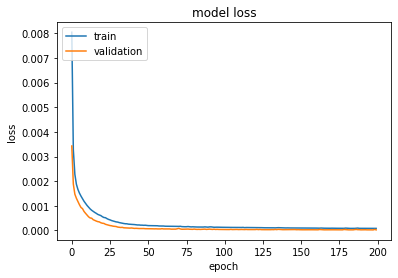

In [33]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
# Save the weight
filename="LSTM_MFS1000_weight1" #1 without k #2 without l
filepath = filename+".hdf5"
model.save_weights(filepath)

# Initializer

## RBFN

In [39]:
# Define the RBF network
class RBFnetwork:
    def __init__(self, input_dim, num_centers, radius, out_dim):
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.out_dim = out_dim
        self.beta = radius
        self.centers = [np.random.uniform(-1,1,input_dim) for i in range(num_centers)]
        self.w = np.random.random((self.num_centers, self.out_dim))
        
    def _basisfunc(self, c, d):
        return np.exp(-self.beta*norm(d-c)**2) # Gaussian
        
    def _calcAct(self,X):
        G = np.zeros((X.shape[0],self.num_centers), dtype = np.float64)
        for ci,c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
        pass   
        
    def train(self, X, Y, num_centers):
        km = KMeans(num_centers) # k-means to find the centers
        km.fit(X)
        km_centers = km.cluster_centers_
        self.centers = km_centers 
        
        # Calculate the activation function of RBF
        G = self._calcAct(X)
        # self.w = np.dot(pinv(G),Y) # inverse
        self.w = tf.linalg.lstsq(G, Y).numpy() # LSE is applied to calculate w
        pass
    
    def predict(self,X):
        G = self._calcAct(X)
        Y = np.dot(G,self.w)
        return Y

In [40]:
# Training ata
tr_por = 900
data_train_rbf = data_total[:tr_por,:,:]

RBFNlabels = data_train_rbf[:,0,[10,11]].reshape(data_train_rbf.shape[0],2)
print(RBFNlabels.shape)

# Static data
x_static_rbf = data_train_rbf[:,0,[0,1,2,3,6,7]]
static_inputs = x_static_rbf
print(static_inputs.shape)

(900, 2)
(900, 6)


In [41]:
# testing ata
tr_por = -100
data_test_rbf = data_total[tr_por:,:,:]

RBFNlabels_test = data_test_rbf[:,0,[10,11]].reshape(data_test_rbf.shape[0],2)
print(RBFNlabels_test.shape)

# Static data
x_static_rbf_test = data_test_rbf[:,0,[0,1,2,3,6,7]]
static_inputs_test = x_static_rbf_test
print(static_inputs_test.shape)

(100, 2)
(100, 6)


In [42]:
# Train the RBFN
input_dim = static_inputs.shape[1]
kernel_num = 100 #optimum 100
RBFN_r = 0.1 #optimum 0.1
output_dim = RBFNlabels.shape[1]

rbf = RBFnetwork(input_dim,kernel_num,RBFN_r,output_dim)
start_time = time.time() # record the time training the model
rbf.train(static_inputs,RBFNlabels,kernel_num)
print("--- %s seconds ---" % (time.time() - start_time))

RBFpredict = rbf.predict(static_inputs) # train
RBFpredict_test = rbf.predict(static_inputs_test)
RBF_score = mean_squared_error(RBFNlabels[:,0], RBFpredict[:,0],squared=False)
RBF_score2 = mean_squared_error(RBFNlabels[:,1], RBFpredict[:,1],squared=False)
RBF_scoret = mean_squared_error(RBFNlabels_test[:,0], RBFpredict_test[:,0],squared=False)
RBF_scoret2 = mean_squared_error(RBFNlabels_test[:,1], RBFpredict_test[:,1],squared=False)
print('Validation Score:',RBF_score,',',RBF_score2)
print('Testing Score:',RBF_scoret,',',RBF_scoret2)

--- 1.0242619514465332 seconds ---
Validation Score: 0.056993207519532046 , 0.08112866644388463
Testing Score: 0.06736830771930225 , 0.10052451404354665


<Figure size 576x504 with 0 Axes>

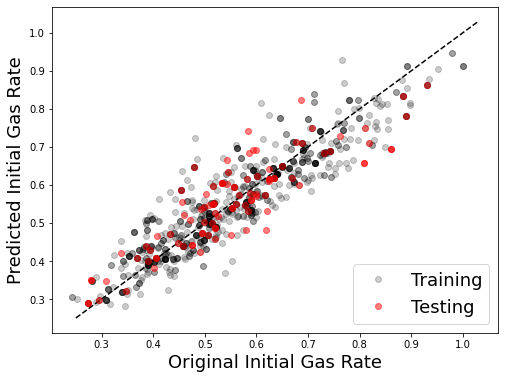

In [52]:
plt.figure(figsize=(8,7))
RBFpredict = rbf.predict(static_inputs) # train
RBFpredict_test = rbf.predict(static_inputs_test)
plt.figure(figsize=(8,6))
plt.plot([0.25,1.03], [0.25,1.03], 'k--')
plt.plot(RBFNlabels[:,0],RBFpredict[:,0],'ko',alpha=.2,label='Training')
plt.plot(RBFNlabels_test[:,0],RBFpredict_test[:,0],'ro',alpha=.5,label='Testing')
plt.xlabel('Original Initial Gas Rate',fontsize=18)
plt.ylabel('Predicted Initial Gas Rate',fontsize=18)
plt.legend(loc=4,fontsize=18)

<Figure size 576x504 with 0 Axes>

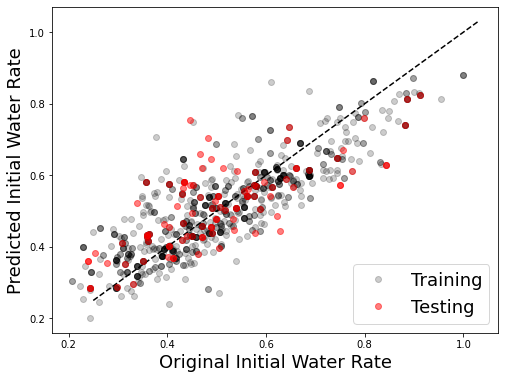

In [55]:
plt.figure(figsize=(8,7))
RBFpredict = rbf.predict(static_inputs) # train
RBFpredict_test = rbf.predict(static_inputs_test)
plt.figure(figsize=(8,6))
plt.plot([0.25,1.03], [0.25,1.03], 'k--')
plt.plot(RBFNlabels[:,1],RBFpredict[:,1],'ko',alpha=.2,label='Training')
plt.plot(RBFNlabels_test[:,1],RBFpredict_test[:,1],'ro',alpha=.5,label='Testing')
plt.xlabel('Original Initial Water Rate',fontsize=18)
plt.ylabel('Predicted Initial Water Rate',fontsize=18)
plt.legend(loc=4,fontsize=18)

## Recursively Updated Forecasting (RUF)

In [238]:
def local_RMSE(testY, testPredict):
    scaler = MinMaxScaler()
    scaler.fit(testY.reshape(-1,1))
    norm_y_label = scaler.transform(testY.reshape(-1,1))
    norm_y_pred = scaler.transform(testPredict.reshape(-1,1))
    testScore = mean_squared_error(norm_y_label, norm_y_pred,squared=False)
    return testScore

In [268]:
def RUF_prepare(testX, testX_test,init_pred,pred_idx,i):
    testX_test[:,:,pred_idx] = 0
    
    if i == 0:
        testX_test[0,0,[-2,-1]] = init_pred # first value = predicted value by initializer
    else:
        testX_test[0,0:i,pred_idx] = testX[0,0:i,pred_idx]
        
    return testX_test

In [274]:
def RUF_process(model, prod_period, testX_test, testY):
    if prod_period > 0:
        prod_period-=1
        
    for ii in range(testX_test.shape[1]-1-prod_period):
        org_test = model.predict(testX_test,verbose=0)
        org_update = org_test[:,ii+prod_period]
        testX_test[:,ii+prod_period+1,[-2,-1]] = org_update
        
    # Final step prediction    
    pred_copy_test = model.predict(testX_test,verbose=0)  
    
    if prod_period > 0:
        pred_copy_test[0,:prod_period,:]= testY[0,:prod_period,:]
        
    return pred_copy_test

Plot time: 0
LSTM_MFS1000_weight1.hdf5
LSTM_MFS1000_weight2.hdf5
LSTM_MFS1000_weight3.hdf5
LSTM_MFS1000_weight4.hdf5
LSTM_MFS1000_weight5.hdf5
Plot time: 3
LSTM_MFS1000_weight1.hdf5
LSTM_MFS1000_weight2.hdf5
LSTM_MFS1000_weight3.hdf5
LSTM_MFS1000_weight4.hdf5
LSTM_MFS1000_weight5.hdf5
Plot time: 5
LSTM_MFS1000_weight1.hdf5
LSTM_MFS1000_weight2.hdf5
LSTM_MFS1000_weight3.hdf5
LSTM_MFS1000_weight4.hdf5
LSTM_MFS1000_weight5.hdf5
Plot time: 10
LSTM_MFS1000_weight1.hdf5
LSTM_MFS1000_weight2.hdf5
LSTM_MFS1000_weight3.hdf5
LSTM_MFS1000_weight4.hdf5
LSTM_MFS1000_weight5.hdf5


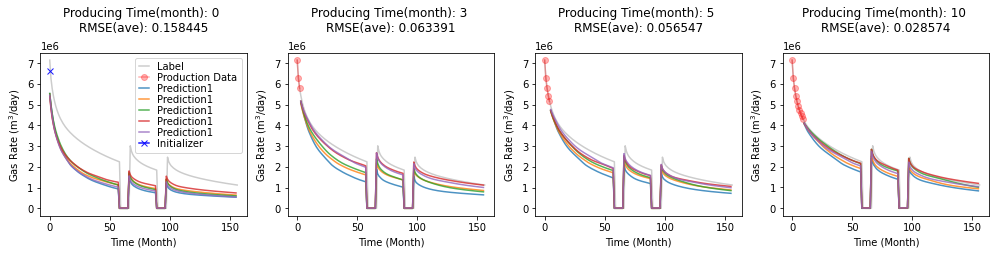

In [280]:
# Perform the RUF and plot the curves
plot_case = 67
pred_feature = -2
pred_idx = [-1,-2] # -1 is water, -2 is gas
model_num = 5
prod_period_list = [0,3,5,10]
fig, ax = plt.subplots(1 , 4, figsize=(17,3))

for i, subplot_ax in enumerate(ax):
    plot_t = prod_period_list[i]
    print(f"Plot time: {plot_t}")

    # plot labels
    subplot_ax.plot(list(range(157)), data_test[plot_case,:,pred_feature]*(max_qg - min_qg) + min_qg,'k-',label='Label',alpha=0.2)
    subplot_ax.plot(list(range(plot_t)), inputs_test[plot_case,:plot_t,pred_feature]*(max_qg - min_qg) + min_qg,'ro-',label='Production Data', alpha=0.3)
    
    # guess the first value
    testX = inputs_test[[plot_case],:,:]
    testY = labels_test[[plot_case],:,:]
    
    RBFN_peak = rbf.predict(testX[:,0,:6]).reshape(-1) # results form the initializer
    testX_test = RUF_prepare(testX.copy(),testX.copy(),RBFN_peak,pred_idx,plot_t)
    
    # RUF prediction
    tePred = []
    teScore = []
    for jj in range(5):
        filepath ="LSTM_MFS1000_weight"+str(jj+1)+".hdf5"
        print(filepath)
        model.load_weights(filepath)
        pred_copy_test = RUF_process(model, plot_t, testX_test, testY)
        testScore = local_RMSE(testY[0,:,0],pred_copy_test[0,:,0])
        teScore.append(testScore)
        label_predict = 'Prediction'+ str(i+1)
        subplot_ax.plot(list(range(plot_t,156)), pred_copy_test[0,plot_t:,0]*(max_qg - min_qg) + min_qg,
                        label = label_predict, alpha=0.8)
        
    if plot_t == 0:
        subplot_ax.plot(0,RBFN_peak[pred_feature]*(maxx - minn) + minn,'bx-',alpha=.9,label='Initializer')
        legend = subplot_ax.legend(loc='upper right',ncol=1,labelspacing=0.1, handlelength=1.0)
        for text in legend.get_texts():
            text.set_fontsize(10)
            
    testScore_ave = sum(teScore)/len(teScore)
    subplot_ax.set_title('Producing Time(month): %d \n' %(plot_t) +  'RMSE(ave): %.6f\n' % (testScore_ave))
    subplot_ax.set_xlabel('Time (Month)')
    subplot_ax.set_ylabel('Gas Rate (m$^{3}$/day)')